# PCA
---

#### Overview

Using dimensionality to determine which features are driving variation between groups of interest. 
Here we use principal component analysis based on the motility metrics to differences between groups relating to the three variables: 1) time in water, 2) position in tube, 3) level of confinement. 


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

## Load Motility Metrics
---

Load summary motility metrics from all cells swimming in pools generated in `1_Compute...`.

#### Datasets
```
1. AMID04 :: 01 March 2024
1. AMID05 :: 01 March 2024
```

#### Experimental parameters
| strain  | substrate      | position_in_tube | time_in_water |
|---------|----------------|------------------|---------------|
| cc1373  | pools          | top              | 4 hrs         |
|         | wells          | middle           | 21 hrs        |

#### Collect csv files

In [2]:
csv_files = {
    "AMID-04": Path("../data/AMID-04_summary_motility_metrics.csv"),
    "AMID-05": Path("../data/AMID-05_summary_motility_metrics.csv"),
}

motility_metrics_dataframe = pd.concat(
    [pd.read_csv(csv_file) for csv_file in csv_files.values()],
)

motility_metrics_dataframe.drop("slide_ID", axis=1).groupby("experiment_ID").head(4)

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,experiment_ID,strain,substrate,position_in_tube,time_in_water,well_ID,timelapse_ID,pool_ID
0,10.452090,405.988485,53.390512,15.908359,0.131507,38.842804,5.108118,4.151206,0.0,27,0.066504,3,AMID-04,cc1373,pools,top,21,NaN,1.0,2x2
1,19.953990,512.993208,40.957943,9.852008,0.079841,25.708804,2.052619,2.376976,1.0,31,0.060430,1,AMID-04,cc1373,pools,top,21,NaN,1.0,2x3
2,10.702140,478.449134,68.669244,14.376490,0.143525,44.705931,6.416403,2.781357,2.0,21,0.043892,2,AMID-04,cc1373,pools,top,21,NaN,1.0,3x1
3,19.953990,925.335760,76.357094,14.874829,0.082518,46.373470,3.826658,2.660577,1.0,33,0.035663,1,AMID-04,cc1373,pools,top,21,NaN,1.0,3x2
0,19.954072,47.628602,31.877719,0.824480,0.669298,2.386911,1.597555,4.640156,0.0,84,1.763646,19,AMID-05,cc1373,wells,top,21,I02,NaN,NaN
1,19.954072,90.879026,32.830895,1.592052,0.361259,4.554410,1.645323,10.093640,1.0,133,1.463484,19,AMID-05,cc1373,wells,top,21,I02,NaN,NaN
2,19.954072,169.036297,38.048613,3.997798,0.225091,8.471268,1.906809,3.406205,4.0,44,0.260299,19,AMID-05,cc1373,wells,top,21,I02,NaN,NaN
3,19.954072,74.651114,43.324461,1.406703,0.580359,3.741147,2.171209,6.367813,0.0,130,1.741434,19,AMID-05,cc1373,wells,top,21,I02,NaN,NaN


## PCA
---

#### Select metrics to construct PCA.

In [3]:
# set metrics
metrics_subset = [
    "max_sprint_length",
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_linear_speed",
    "mean_angular_speed",
    "pivot_rate",
]

# set experimental variables
experimental_variables = [
    "position_in_tube",
    "time_in_water",
    "substrate",
]

#### Choose number of components

Choose number of components that capture 95% of the variance.

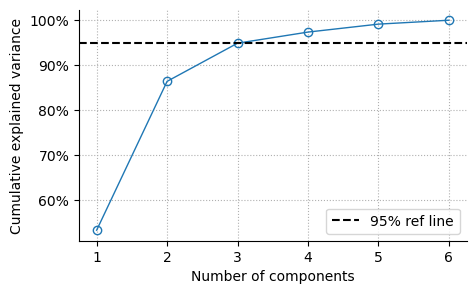

In [4]:
# min-max normalization
minmax_range = (
    motility_metrics_dataframe[metrics_subset].max()
    - motility_metrics_dataframe[metrics_subset].min()
)
motility_metrics_normalized = (
    motility_metrics_dataframe[metrics_subset] - motility_metrics_dataframe[metrics_subset].min()
) / minmax_range

# cumulative explained variance
pca_cumulative_variance = PCA().fit(motility_metrics_normalized)
cumulative_variance = np.cumsum(pca_cumulative_variance.explained_variance_ratio_)
num_components = np.arange(cumulative_variance.size) + 1

# create figure
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(num_components, 100 * cumulative_variance, "o-", lw=1, mfc="none")
ax.axhline(95, color="k", ls="--", label="95% ref line")

# aesthetics
sns.despine(ax=ax)
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc=4)
ax.grid(ls=":")

#### Build PCA

In [5]:
# PCA
num_pca_components = num_components[cumulative_variance > 0.95][0]
pca = PCA(n_components=num_pca_components)
motility_components = pca.fit_transform(motility_metrics_normalized)

# add PCA component to dataframe
for i in range(num_pca_components):
    key = f"PC-{i + 1}"
    motility_metrics_dataframe[key] = motility_components[:, i]

#### PCA Weights

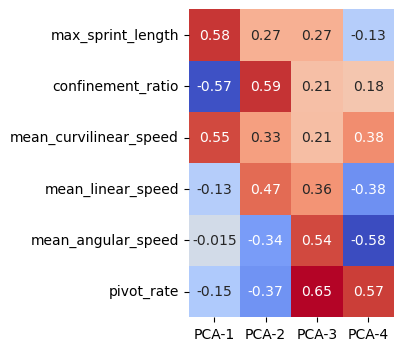

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(
    pca.components_.T,
    cmap="coolwarm",
    xticklabels=[f"PCA-{i}" for i in range(1, pca.n_components_ + 1)],
    yticklabels=metrics_subset,
    annot=True,
    square=True,
    cbar=False,
    ax=ax,
);

#### PCA for each experimental variable

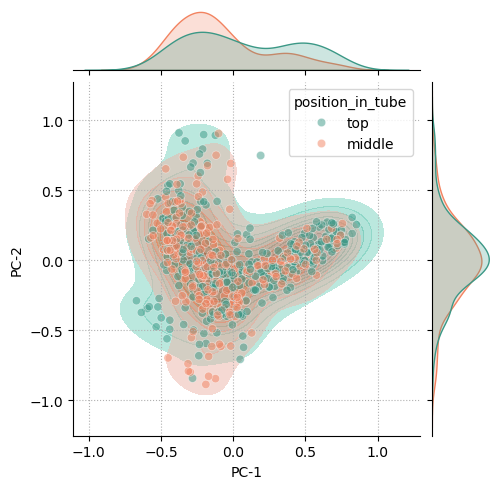

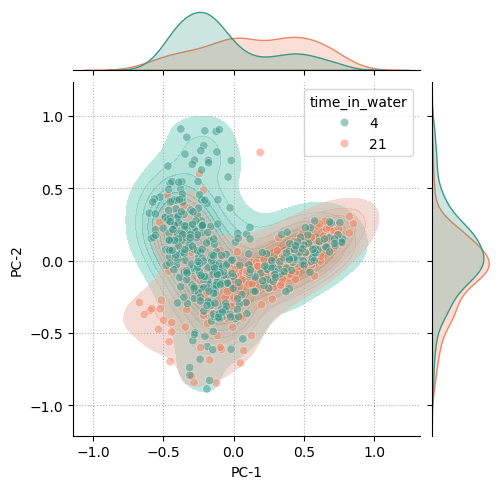

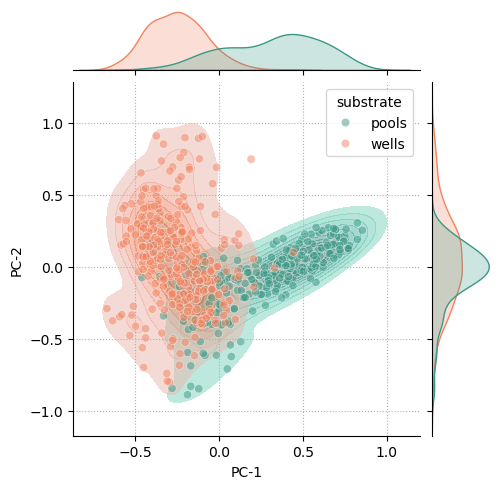

In [7]:
# loop through experimental variables
# (position in tube and time in water)
for variable in experimental_variables:
    # render joint distribution
    g = sns.JointGrid(
        data=motility_metrics_dataframe,
        x="PC-1",
        y="PC-2",
        hue=variable,
        palette=["#3B9886", "#F28360"],
        height=5,
    )

    # aesthetics
    g.plot_joint(sns.kdeplot, fill=True, alpha=0.5)
    g.plot_joint(sns.scatterplot, alpha=0.5, legend=True)
    g.plot_marginals(sns.kdeplot, fill=True, common_norm=False)
    g.ax_joint.grid(ls=":")